# Multi-Model Object Detection Pipeline

## Overview
This notebook demonstrates inference with multiple pre-trained object detection models for workplace safety compliance. The models detect various safety equipment and body parts including hairnets, helmets, gloves, heads, hands, and persons.

## Notebook Structure

1. **Setup**: Mount drive, set directories, install dependencies
2. **Dataset Loading**: Load reference dataset for sample images
3. **Model Loading**: Load all 4 pre-trained models
   - Hairnet Detection (YOLOv8)
   - Head Detection (YOLOv8)
   - Glove Detection (YOLOv8)
   - Hand Detection (Faster R-CNN with FPN)
4. **Sample Selection**: Choose an image for inference
5. **Inference Pipeline**: Run all models sequentially on the selected image

---

## 1. Setup Directories

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In your working directory you need to have a 'models' folder with the four models. Notice that hand model also requires two .yaml files.

In [103]:
import os
os.chdir('/content/drive/MyDrive/Computer_Vision/Project/final_report')
print(f"Working directory set to: {os.getcwd()}")

# Display directory structure
print("\n" + "="*60)
print("Directory Structure:")
print("="*60)

def display_directory_tree(path='.', prefix='', max_depth=2, current_depth=0):
    """Display directory tree structure"""
    if current_depth >= max_depth:
        return

    try:
        items = sorted(os.listdir(path))
        dirs = [item for item in items if os.path.isdir(os.path.join(path, item))]
        files = [item for item in items if os.path.isfile(os.path.join(path, item))]

        # Show directories first
        for i, item in enumerate(dirs):
            is_last_dir = (i == len(dirs) - 1) and len(files) == 0
            connector = "└── " if is_last_dir else "├── "
            print(f"{prefix}{connector}{item}/")

            # Recursively show subdirectories
            extension = "    " if is_last_dir else "│   "
            item_path = os.path.join(path, item)
            display_directory_tree(item_path, prefix + extension, max_depth, current_depth + 1)

        # Show files (limit to first 10)
        for i, item in enumerate(files[:10]):
            is_last = i == len(files) - 1 or i == 9
            connector = "└── " if is_last else "├── "
            print(f"{prefix}{connector}{item}")

        if len(files) > 10:
            print(f"{prefix}    ... and {len(files) - 10} more files")

    except PermissionError:
        print(f"{prefix}(permission denied)")

print(f"./ (working directory)")
display_directory_tree()

print("="*60)

Working directory set to: /content/drive/MyDrive/Computer_Vision/Project/final_report

Directory Structure:
./ (working directory)
├── Hair-Net-Detection-3/
│   ├── test/
│   ├── train/
│   ├── valid/
│   ├── README.dataset.txt
│   ├── README.roboflow.txt
│   └── data.yaml
├── models/
│   ├── Base-RCNN-FPN.yaml
│   ├── faster_test.yaml
│   ├── glove_model.pt
│   ├── hairnet_model.pt
│   ├── hand_model.pth
│   └── head_model.pt
├── negative_hair_samples/
│   ├── images/
│   └── labels/
├── combined_detections.png
├── glove_prediction.png
├── hand_prediction.png
├── head_prediction.png
├── multi_model_inference.png
├── ppe_verification.png
├── sample_images_visualization.png
└── sample_prediction.png


## 2. Install Dependencies & Import Libraries

In [ ]:
# ==================== INSTALLATION ====================
!pip install -q ultralytics roboflow matplotlib seaborn opencv-python

In [104]:
# ==================== IMPORTS ====================
import os
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from roboflow import Roboflow
from ultralytics import YOLO
import glob
from PIL import Image
import shutil

In [ ]:
import warnings

warnings.filterwarnings(
    "ignore",
    message=r".*datetime\.datetime\.utcnow\(\) is deprecated.*",
    category=DeprecationWarning,
)

## 3. Load Dataset

Load the hairnet detection dataset to access sample images for inference.

In [105]:
# ==================== DATASET DOWNLOAD ====================
print("Downloading dataset from Roboflow...")
rf = Roboflow(api_key="JOyOsX2ve6Gbpk8A4pfD")
project = rf.workspace("mdlz-automation").project("hair-net-detection-rpava")
version = project.version(3)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


In [106]:
# ==================== DATA EXPLORATION ====================
print("\nDataset Structure:")
dataset_path = dataset.location
print(f"Dataset location: {dataset_path}")

# Load data.yaml
with open(f"{dataset_path}/data.yaml", 'r') as f:
    data_config = yaml.safe_load(f)

print(f"\nClasses: {data_config['names']}")
print(f"Number of classes: {data_config['nc']}")

# Count images in each split
train_images = glob.glob(f"{dataset_path}/train/images/*")
valid_images = glob.glob(f"{dataset_path}/valid/images/*")
test_images = glob.glob(f"{dataset_path}/test/images/*") if os.path.exists(f"{dataset_path}/test/images") else []

print(f"\nDataset Statistics:")
print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(valid_images)}")
print(f"Test images: {len(test_images)}")


Dataset Structure:
Dataset location: /content/drive/MyDrive/Computer_Vision/Project/final_report/Hair-Net-Detection-3

Classes: ['hairnet', 'helmet', 'person']
Number of classes: 3

Dataset Statistics:
Training images: 1317
Validation images: 369
Test images: 200


## 4. Load Pre-trained Models

Load all four detection models that will be used for inference.

In [107]:
# ==================== LOAD ALL MODELS ====================
from ultralytics import YOLO
import torch

print("Loading pre-trained models...\n")

# 1. Hairnet Detection Model (YOLOv8)
print("Loading hairnet model...")
hairnet_model = YOLO('models/hairnet_model.pt')
print("✅ Hairnet model loaded")

# 2. Head Detection Model (YOLOv8)
print("\nLoading head model...")
head_model = YOLO('models/head_model.pt')
print("✅ Head model loaded")

# 3. Glove Detection Model (YOLOv8)
print("\nLoading glove model...")
glove_model = YOLO('models/glove_model.pt')
print("✅ Glove model loaded")

# 4. Hand Detection Model (Detectron2 - Faster R-CNN)
print("\nLoading hand detection model...")

# Check if Detectron2 is installed
try:
    import detectron2
    print("✅ Detectron2 already installed")
except ImportError:
    print("Installing Detectron2 (first time only, may take 3-5 minutes)...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q",
                          "git+https://github.com/facebookresearch/detectron2.git"])
    import detectron2
    print("✅ Detectron2 installed")

from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

# Setup hand model configuration
cfg = get_cfg()
cfg.merge_from_file("models/Base-RCNN-FPN.yaml")
cfg.merge_from_file("models/faster_test.yaml")
cfg.MODEL.WEIGHTS = "models/hand_model.pth"
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.25

hand_predictor = DefaultPredictor(cfg)
print("✅ Hand model loaded")

print("\n" + "="*60)
print("All 4 models loaded successfully!")
print("="*60)

Loading pre-trained models...

Loading hairnet model...
✅ Hairnet model loaded

Loading head model...
✅ Head model loaded

Loading glove model...
✅ Glove model loaded

Loading hand detection model...
✅ Detectron2 already installed
✅ Hand model loaded

All 4 models loaded successfully!


## 5. Select Sample Image

Choose an image from the dataset for inference. You can either select a random image or specify a custom path.

Using test (custom) image:
   Path: /content/drive/MyDrive/Computer_Vision/Project/final_report/Hair-Net-Detection-3/test/images/difficult_image_03.jpeg
   Filename: difficult_image_03.jpeg

✅ This same image will be used for all model predictions (Sections 11-13)


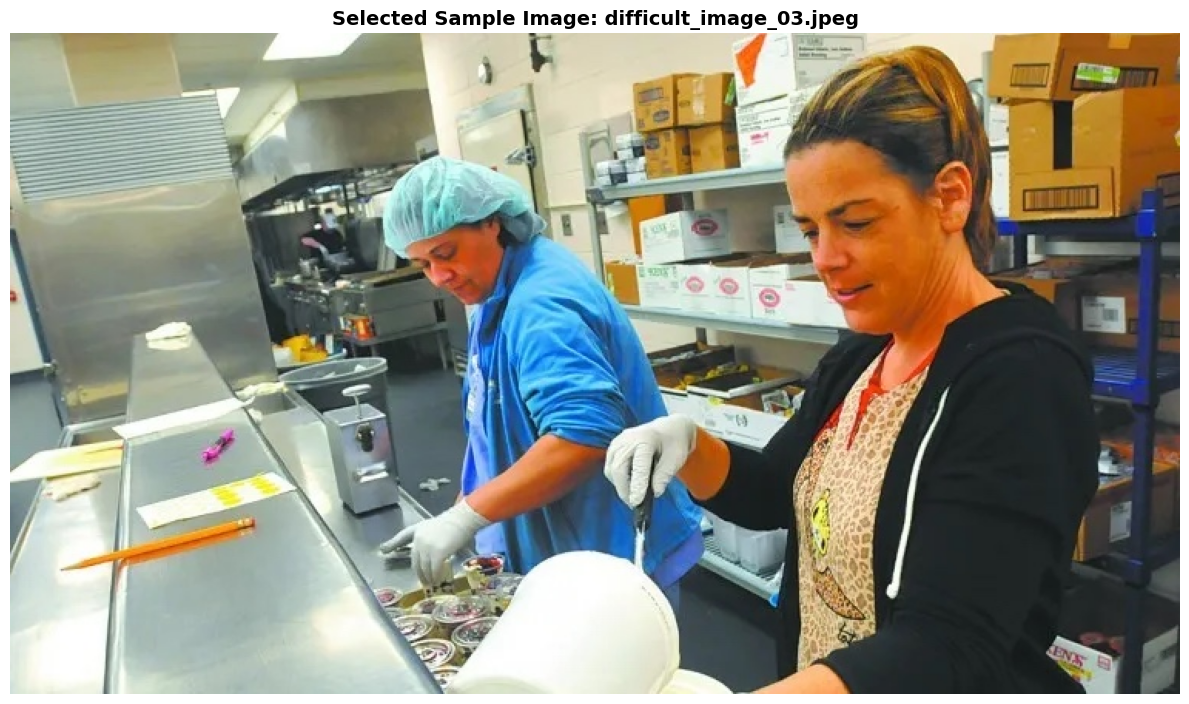


Image dimensions: 759x429 pixels


In [108]:
# ==================== SELECT SAMPLE IMAGE ====================
import random
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# === CONFIGURATION ===
# Option 1: Set to None for random selection (with seed for reproducibility)
# Option 2: Provide just the filename (will search in dataset directories)
# Option 3: Provide full path to any image

# CUSTOM_IMAGE_PATH = None
# CUSTOM_IMAGE_PATH = "resized_121_jpg.rf.fe5158495ae908d0574618436431f9fd.jpg"
# CUSTOM_IMAGE_PATH = "difficult_image_01.jpeg"
# CUSTOM_IMAGE_PATH = "difficult_image_02.png"
CUSTOM_IMAGE_PATH = "difficult_image_03.jpeg"
# =====================

# Set seed for reproducibility
random.seed(42)
np.random.seed(42)

if CUSTOM_IMAGE_PATH is not None:
    # Check if it's a filename or full path
    if os.path.exists(CUSTOM_IMAGE_PATH):
        # Full path provided
        sample_image = CUSTOM_IMAGE_PATH
        dataset_type = "custom"
    else:
        # Filename provided - search in dataset
        found = False
        search_dirs = [
            f"{dataset_path}/test/images",
            f"{dataset_path}/valid/images",
            f"{dataset_path}/train/images"
        ]

        for search_dir in search_dirs:
            potential_path = os.path.join(search_dir, CUSTOM_IMAGE_PATH)
            if os.path.exists(potential_path):
                sample_image = potential_path
                dataset_type = search_dir.split('/')[-2]  # test, valid, or train
                found = True
                break

        if not found:
            print(f"❌ Image not found: {CUSTOM_IMAGE_PATH}")
            print(f"   Searched in: {', '.join(search_dirs)}")
            print(f"\nFalling back to random selection...")
            if test_images:
                sample_image = random.choice(test_images)
                dataset_type = "test"
            else:
                sample_image = random.choice(valid_images)
                dataset_type = "validation"
        else:
            dataset_type = f"{dataset_type} (custom)"

    print(f"Using {dataset_type} image:")
else:
    # Random selection from dataset
    if test_images:
        sample_image = random.choice(test_images)
        dataset_type = "test"
    else:
        sample_image = random.choice(valid_images)
        dataset_type = "validation"
    print(f"Selected {dataset_type} image (seed=42):")

print(f"   Path: {sample_image}")
print(f"   Filename: {sample_image.split('/')[-1]}")
print(f"\n✅ This same image will be used for all model predictions (Sections 11-13)")

# Display the selected image
img = cv2.imread(sample_image)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.title(f'Selected Sample Image: {sample_image.split("/")[-1]}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nImage dimensions: {img_rgb.shape[1]}x{img_rgb.shape[0]} pixels")

## 6. Configure Detection Classes

Select which classes to display from each model. This is useful if you want to focus on specific detections.

In [109]:
# ==================== DETECTION CLASS CONFIGURATION ====================

# Configure which classes to display for each model
# Set to None to show all classes, or provide a list of class names to show

# Hairnet Model - Available classes: ['hairnet', 'helmet', 'person']
# Examples:
#   HAIRNET_CLASSES = None  # Show all classes
#   HAIRNET_CLASSES = ['hairnet']  # Only show hairnet detections
#   HAIRNET_CLASSES = ['hairnet', 'helmet']  # Show hairnet and helmet only
HAIRNET_CLASSES = ['hairnet']  # Default: only show hairnet, hide person/helmet

# Head Model - Classes depend on your trained model
HEAD_CLASSES = None  # Show all classes

# Glove Model - Classes depend on your trained model
GLOVE_CLASSES = ['glove']  # Show all classes

# Hand Model (Detectron2) - Usually just 'hand'
HAND_CLASSES = None  # Show all classes

print("✅ Detection class configuration set:")
print(f"   Hairnet Model: {HAIRNET_CLASSES if HAIRNET_CLASSES else 'All classes'}")
print(f"   Head Model: {HEAD_CLASSES if HEAD_CLASSES else 'All classes'}")
print(f"   Glove Model: {GLOVE_CLASSES if GLOVE_CLASSES else 'All classes'}")
print(f"   Hand Model: {HAND_CLASSES if HAND_CLASSES else 'All classes'}")

✅ Detection class configuration set:
   Hairnet Model: ['hairnet']
   Head Model: All classes
   Glove Model: ['glove']
   Hand Model: All classes


## 7. Run Multi-Model Inference

Run all four models sequentially on the selected image and display results.

Running inference with all 4 models...

1. Running hairnet detection...
   ✅ Detections: hairnet: 2

2. Running head detection...
   ✅ Detections: head: 2

3. Running glove detection...
   ✅ Detections: glove: 2

4. Running hand detection...
   ✅ Detections: hand: 2


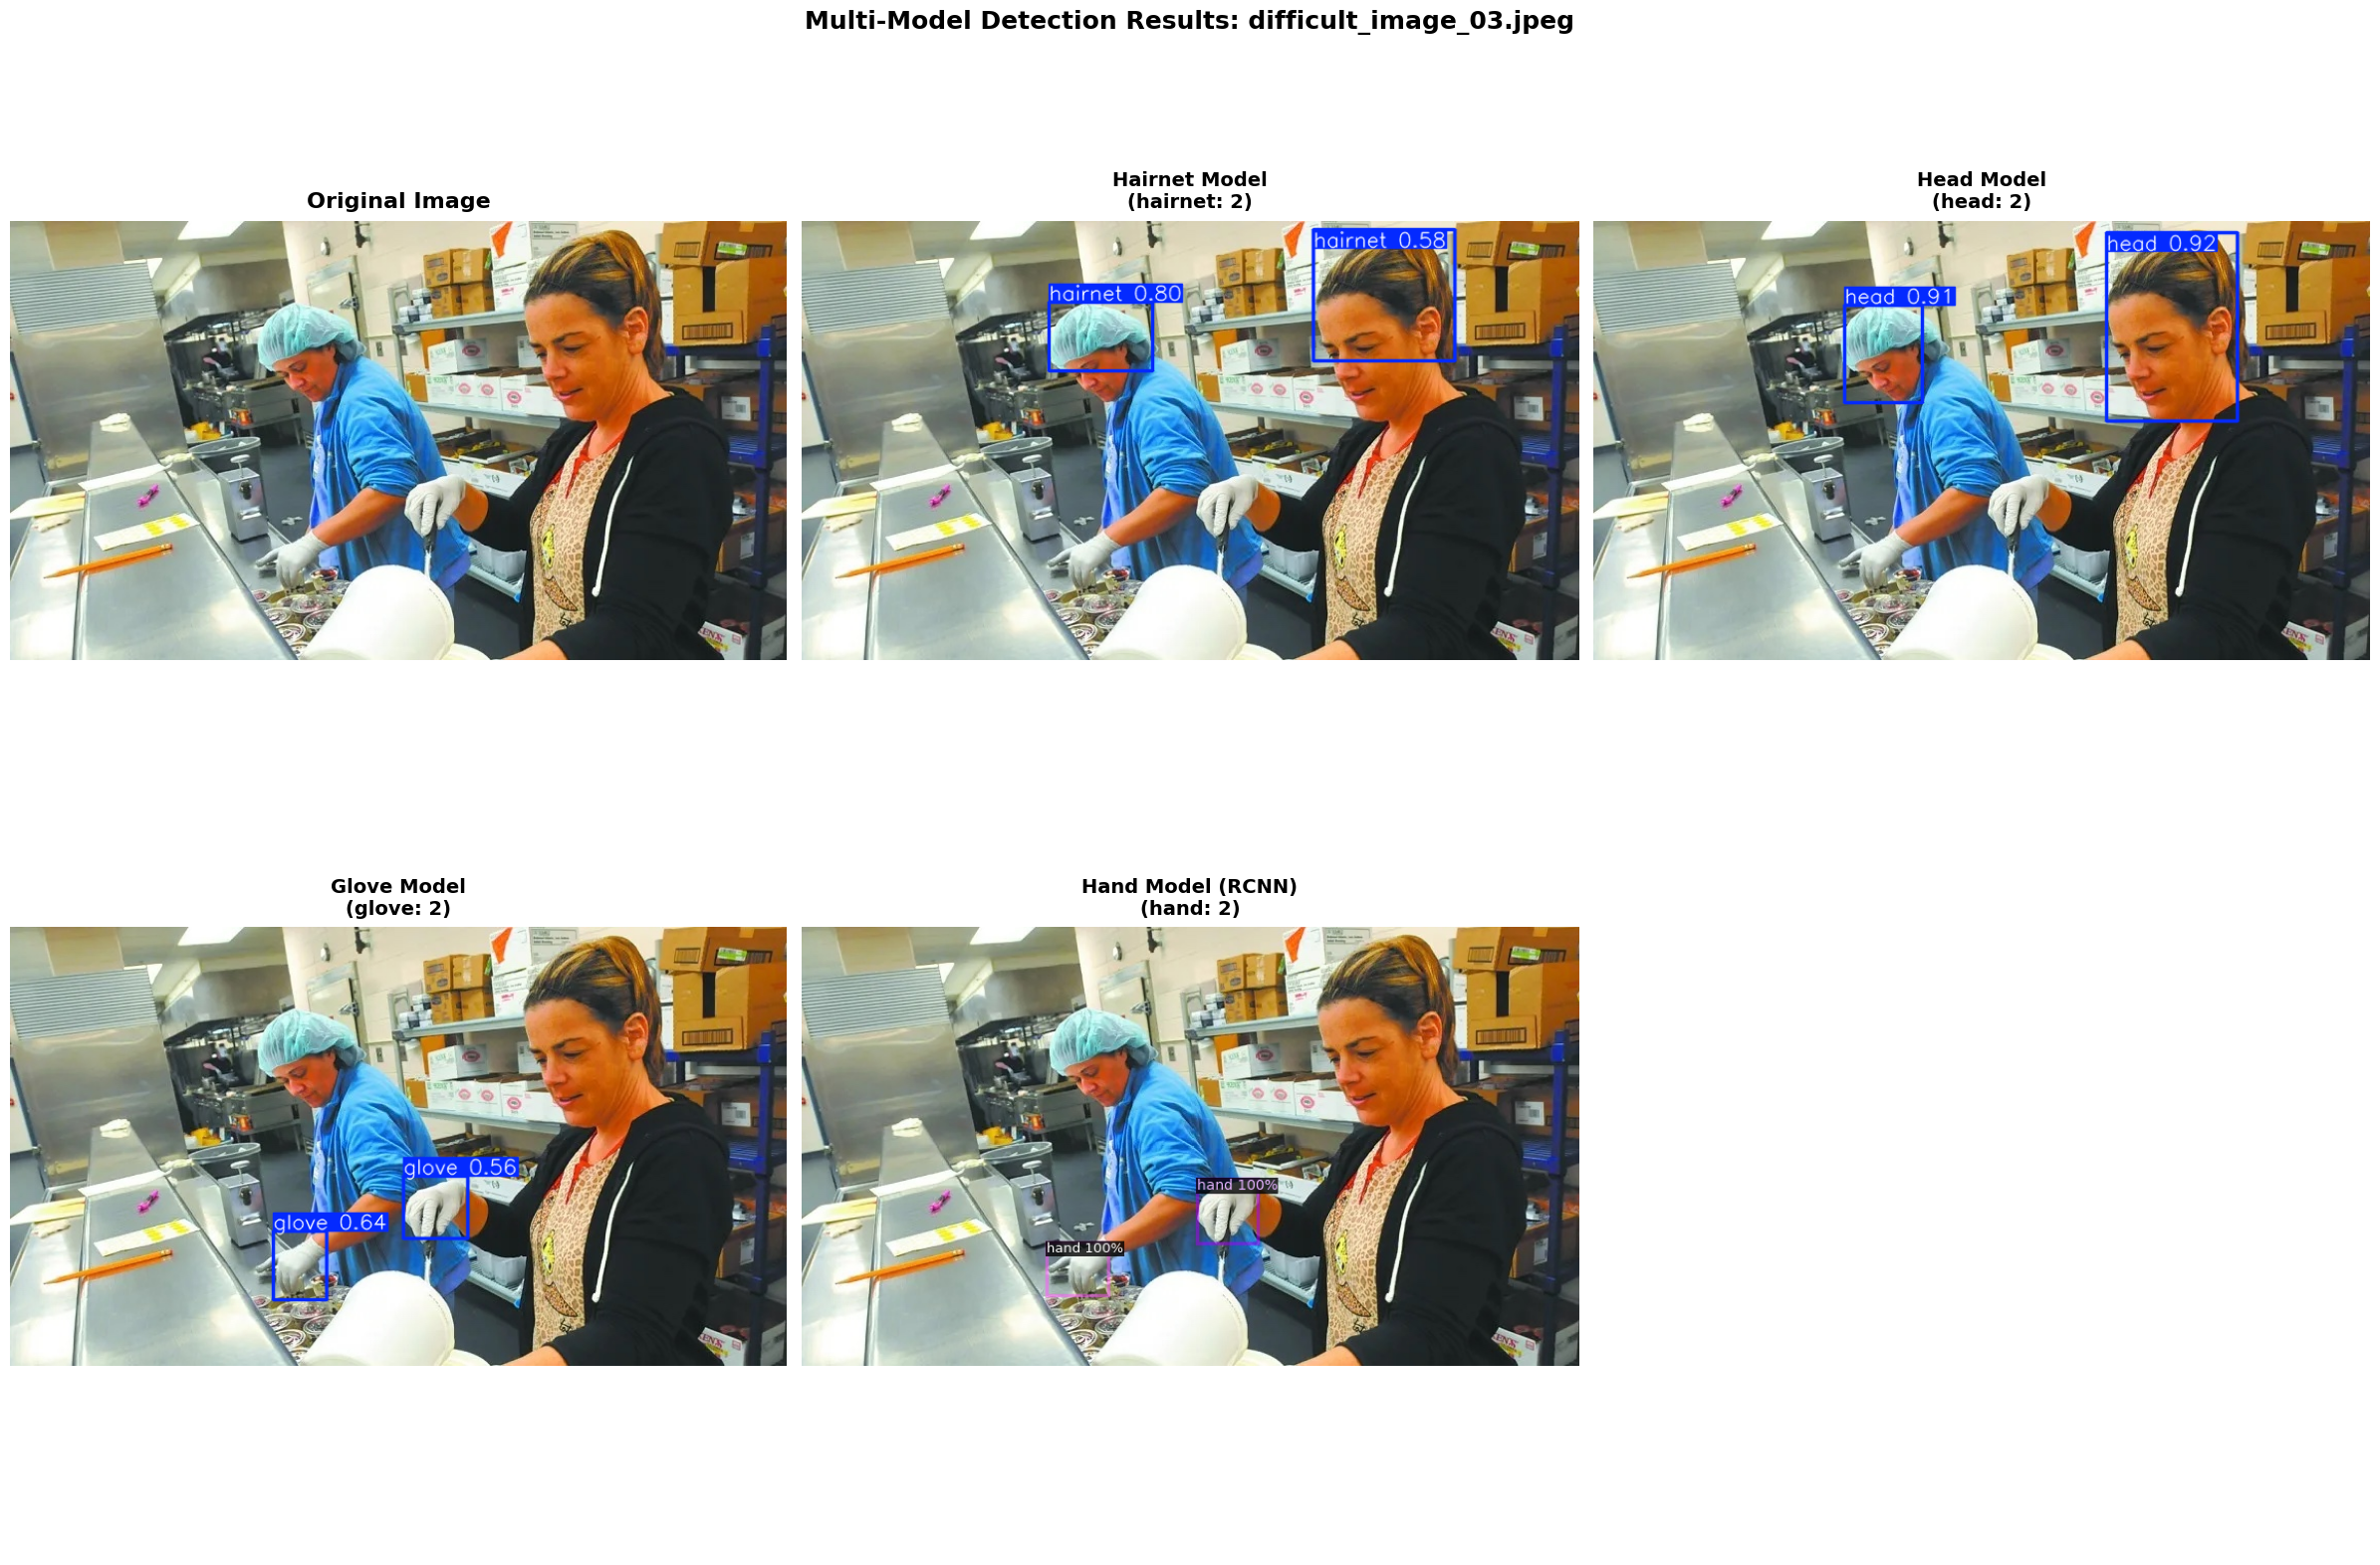


✅ Inference complete! Results saved as 'multi_model_inference.png'


In [110]:
# ==================== RUN INFERENCE WITH ALL MODELS ====================
import cv2
import matplotlib.pyplot as plt
import numpy as np
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog

print("Running inference with all 4 models...\n")

# Read the sample image once
img = cv2.imread(sample_image)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Create figure with 2 rows x 3 columns (original + 4 model predictions)
fig, axes = plt.subplots(2, 3, figsize=(24, 16))
axes = axes.ravel()

# ==================== ORIGINAL IMAGE ====================
axes[0].imshow(img_rgb)
axes[0].axis('off')
axes[0].set_title('Original Image', fontsize=16, fontweight='bold', pad=10)

# ==================== 1. HAIRNET DETECTION ====================
print("1. Running hairnet detection...")
hairnet_results = hairnet_model.predict(sample_image, conf=0.25, iou=0.45, verbose=False)

# Apply class filter by creating a filtered result
if HAIRNET_CLASSES is not None:
    filtered_boxes = []
    for box in hairnet_results[0].boxes:
        cls_id = int(box.cls[0])
        cls_name = data_config['names'][cls_id]
        if cls_name in HAIRNET_CLASSES:
            filtered_boxes.append(box)

    # Update results with filtered boxes
    from copy import deepcopy
    hairnet_results_filtered = deepcopy(hairnet_results)
    if filtered_boxes:
        hairnet_results_filtered[0].boxes = hairnet_results[0].boxes.__class__(
            torch.stack([box.data for box in filtered_boxes]),
            hairnet_results[0].orig_shape
        )
    else:
        # No boxes after filtering
        hairnet_results_filtered[0].boxes = hairnet_results[0].boxes.__class__(
            torch.empty((0, 6)),
            hairnet_results[0].orig_shape
        )
    hairnet_img = hairnet_results_filtered[0].plot()
else:
    hairnet_img = hairnet_results[0].plot()

hairnet_img_rgb = cv2.cvtColor(hairnet_img, cv2.COLOR_BGR2RGB)

axes[1].imshow(hairnet_img_rgb)
axes[1].axis('off')

# Count detections (with class filtering)
boxes = hairnet_results[0].boxes
if boxes is not None and len(boxes) > 0:
    det_counts = {}
    for box in boxes:
        cls_id = int(box.cls[0])
        cls_name = data_config['names'][cls_id]
        # Apply class filter
        if HAIRNET_CLASSES is None or cls_name in HAIRNET_CLASSES:
            det_counts[cls_name] = det_counts.get(cls_name, 0) + 1

    if det_counts:
        det_text = ', '.join([f"{k}: {v}" for k, v in det_counts.items()])
        axes[1].set_title(f'Hairnet Model\n({det_text})', fontsize=14, fontweight='bold', pad=10)
        print(f"   ✅ Detections: {det_text}")
    else:
        axes[1].set_title('Hairnet Model\n(No detections - filtered)', fontsize=14, fontweight='bold', pad=10)
        print("   No detections (after filtering)")
else:
    axes[1].set_title('Hairnet Model\n(No detections)', fontsize=14, fontweight='bold', pad=10)
    print("   No detections")

# ==================== 2. HEAD DETECTION ====================
print("\n2. Running head detection...")
head_results = head_model.predict(sample_image, conf=0.25, iou=0.45, verbose=False)

# Apply class filter
if HEAD_CLASSES is not None:
    filtered_boxes = []
    head_class_names = head_model.names
    for box in head_results[0].boxes:
        cls_id = int(box.cls[0])
        cls_name = head_class_names[cls_id]
        if cls_name in HEAD_CLASSES:
            filtered_boxes.append(box)

    from copy import deepcopy
    head_results_filtered = deepcopy(head_results)
    if filtered_boxes:
        head_results_filtered[0].boxes = head_results[0].boxes.__class__(
            torch.stack([box.data for box in filtered_boxes]),
            head_results[0].orig_shape
        )
    else:
        head_results_filtered[0].boxes = head_results[0].boxes.__class__(
            torch.empty((0, 6)),
            head_results[0].orig_shape
        )
    head_img = head_results_filtered[0].plot()
else:
    head_img = head_results[0].plot()

head_img_rgb = cv2.cvtColor(head_img, cv2.COLOR_BGR2RGB)

axes[2].imshow(head_img_rgb)
axes[2].axis('off')

boxes = head_results[0].boxes
if boxes is not None and len(boxes) > 0:
    head_class_names = head_model.names
    det_counts = {}
    for box in boxes:
        cls_id = int(box.cls[0])
        cls_name = head_class_names[cls_id]
        if HEAD_CLASSES is None or cls_name in HEAD_CLASSES:
            det_counts[cls_name] = det_counts.get(cls_name, 0) + 1

    if det_counts:
        det_text = ', '.join([f"{k}: {v}" for k, v in det_counts.items()])
        axes[2].set_title(f'Head Model\n({det_text})', fontsize=14, fontweight='bold', pad=10)
        print(f"   ✅ Detections: {det_text}")
    else:
        axes[2].set_title('Head Model\n(No detections - filtered)', fontsize=14, fontweight='bold', pad=10)
        print("   No detections (after filtering)")
else:
    axes[2].set_title('Head Model\n(No detections)', fontsize=14, fontweight='bold', pad=10)
    print("   No detections")

# ==================== 3. GLOVE DETECTION ====================
print("\n3. Running glove detection...")
glove_results = glove_model.predict(sample_image, conf=0.25, iou=0.45, verbose=False)

# Apply class filter
if GLOVE_CLASSES is not None:
    filtered_boxes = []
    glove_class_names = glove_model.names
    for box in glove_results[0].boxes:
        cls_id = int(box.cls[0])
        cls_name = glove_class_names[cls_id]
        if cls_name in GLOVE_CLASSES:
            filtered_boxes.append(box)

    from copy import deepcopy
    glove_results_filtered = deepcopy(glove_results)
    if filtered_boxes:
        glove_results_filtered[0].boxes = glove_results[0].boxes.__class__(
            torch.stack([box.data for box in filtered_boxes]),
            glove_results[0].orig_shape
        )
    else:
        glove_results_filtered[0].boxes = glove_results[0].boxes.__class__(
            torch.empty((0, 6)),
            glove_results[0].orig_shape
        )
    glove_img = glove_results_filtered[0].plot()
else:
    glove_img = glove_results[0].plot()

glove_img_rgb = cv2.cvtColor(glove_img, cv2.COLOR_BGR2RGB)

axes[3].imshow(glove_img_rgb)
axes[3].axis('off')

boxes = glove_results[0].boxes
if boxes is not None and len(boxes) > 0:
    glove_class_names = glove_model.names
    det_counts = {}
    for box in boxes:
        cls_id = int(box.cls[0])
        cls_name = glove_class_names[cls_id]
        if GLOVE_CLASSES is None or cls_name in GLOVE_CLASSES:
            det_counts[cls_name] = det_counts.get(cls_name, 0) + 1

    if det_counts:
        det_text = ', '.join([f"{k}: {v}" for k, v in det_counts.items()])
        axes[3].set_title(f'Glove Model\n({det_text})', fontsize=14, fontweight='bold', pad=10)
        print(f"   ✅ Detections: {det_text}")
    else:
        axes[3].set_title('Glove Model\n(No detections - filtered)', fontsize=14, fontweight='bold', pad=10)
        print("   No detections (after filtering)")
else:
    axes[3].set_title('Glove Model\n(No detections)', fontsize=14, fontweight='bold', pad=10)
    print("   No detections")

# ==================== 4. HAND DETECTION ====================
print("\n4. Running hand detection...")
outputs = hand_predictor(img)

# Visualize with Detectron2
metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0] if len(cfg.DATASETS.TEST) > 0 else "hand_detection")
if not hasattr(metadata, "thing_classes"):
    metadata.thing_classes = ["hand"]

v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.0, instance_mode=ColorMode.IMAGE)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
hand_img_rgb = out.get_image()  # Already in RGB format

axes[4].imshow(hand_img_rgb)
axes[4].axis('off')

instances = outputs["instances"]
num_detections = len(instances)

if num_detections > 0:
    pred_classes = instances.pred_classes.cpu().numpy()
    class_counts = {}
    for cls_id in pred_classes:
        cls_name = metadata.thing_classes[cls_id] if hasattr(metadata, "thing_classes") else f"class_{cls_id}"
        class_counts[cls_name] = class_counts.get(cls_name, 0) + 1
    det_text = ', '.join([f"{k}: {v}" for k, v in class_counts.items()])
    axes[4].set_title(f'Hand Model (RCNN)\n({det_text})', fontsize=14, fontweight='bold', pad=10)
    print(f"   ✅ Detections: {det_text}")
else:
    axes[4].set_title('Hand Model (RCNN)\n(No detections)', fontsize=14, fontweight='bold', pad=10)
    print("   No detections")

# Hide the last subplot (we have 5 images in a 2x3 grid)
axes[5].axis('off')

plt.suptitle(f'Multi-Model Detection Results: {sample_image.split("/")[-1]}',
             fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('multi_model_inference.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("✅ Inference complete! Results saved as 'multi_model_inference.png'")
print("="*60)

## 8. Combined Multi-Model Visualization

Overlay all bounding boxes from all models on a single image, with different colors representing each model.

Creating combined visualization with all model detections...

Hairnet model: 2 detections
Head model: 2 detections
Glove model: 2 detections
Hand model: 2 detections


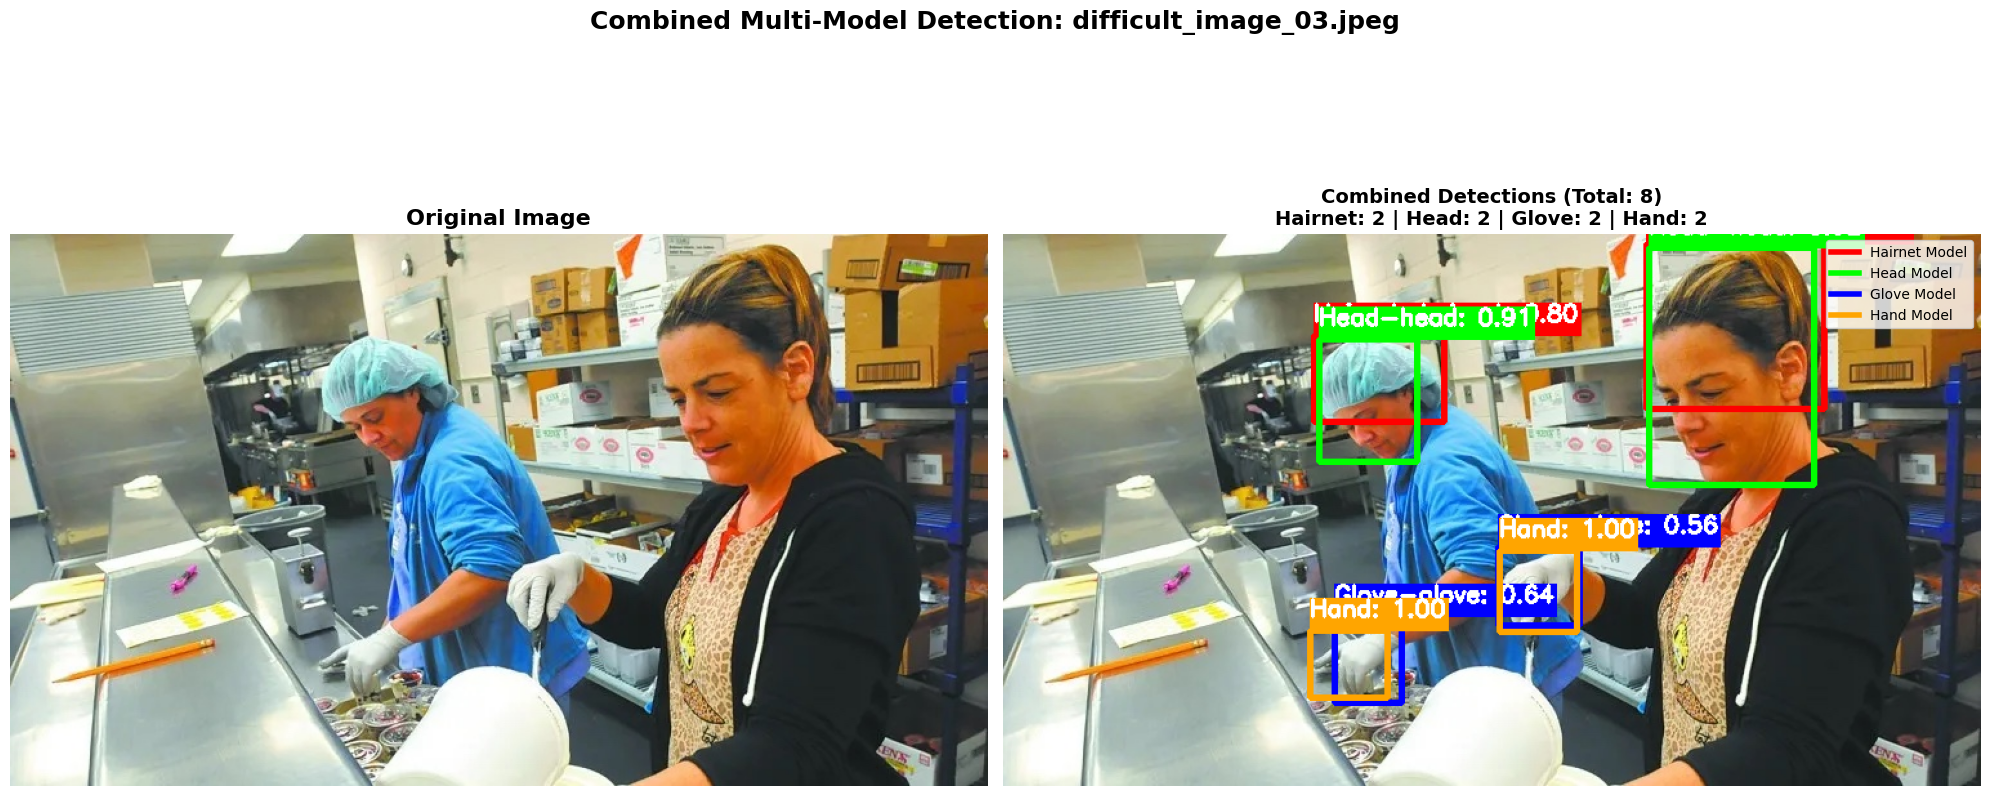


✅ Combined visualization complete!
   Total detections: 8
   • Hairnet: 2
   • Head: 2
   • Glove: 2
   • Hand: 2

   Saved as 'combined_detections.png'


In [111]:
# ==================== COMBINED VISUALIZATION ====================
import cv2
import matplotlib.pyplot as plt
import numpy as np

print("Creating combined visualization with all model detections...\n")

# Read the sample image
img_combined = cv2.imread(sample_image)
img_combined = cv2.cvtColor(img_combined, cv2.COLOR_BGR2RGB)
h, w = img_combined.shape[:2]

# Define colors for each model (RGB format)
COLORS = {
    'hairnet': (255, 0, 0),      # Red
    'head': (0, 255, 0),         # Green
    'glove': (0, 0, 255),        # Blue
    'hand': (255, 165, 0)        # Orange
}

detection_counts = {}

# ==================== 1. DRAW HAIRNET DETECTIONS ====================
boxes = hairnet_results[0].boxes
if boxes is not None and len(boxes) > 0:
    for box in boxes:
        cls_id = int(box.cls[0])
        cls_name = data_config['names'][cls_id]

        # Apply class filter
        if HAIRNET_CLASSES is not None and cls_name not in HAIRNET_CLASSES:
            continue  # Skip this detection

        # Get box coordinates (xyxy format)
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
        conf = float(box.conf[0])

        # Draw bounding box
        cv2.rectangle(img_combined, (x1, y1), (x2, y2), COLORS['hairnet'], 3)

        # Draw label background
        label = f"Hairnet-{cls_name}: {conf:.2f}"
        (label_w, label_h), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
        cv2.rectangle(img_combined, (x1, y1 - label_h - baseline - 5),
                     (x1 + label_w, y1), COLORS['hairnet'], -1)

        # Draw label text
        cv2.putText(img_combined, label, (x1, y1 - baseline - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        detection_counts['hairnet'] = detection_counts.get('hairnet', 0) + 1

print(f"Hairnet model: {detection_counts.get('hairnet', 0)} detections")

# ==================== 2. DRAW HEAD DETECTIONS ====================
boxes = head_results[0].boxes
if boxes is not None and len(boxes) > 0:
    head_class_names = head_model.names
    for box in boxes:
        cls_id = int(box.cls[0])
        cls_name = head_class_names[cls_id]

        # Apply class filter
        if HEAD_CLASSES is not None and cls_name not in HEAD_CLASSES:
            continue  # Skip this detection

        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
        conf = float(box.conf[0])

        cv2.rectangle(img_combined, (x1, y1), (x2, y2), COLORS['head'], 3)

        label = f"Head-{cls_name}: {conf:.2f}"
        (label_w, label_h), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
        cv2.rectangle(img_combined, (x1, y1 - label_h - baseline - 5),
                     (x1 + label_w, y1), COLORS['head'], -1)
        cv2.putText(img_combined, label, (x1, y1 - baseline - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        detection_counts['head'] = detection_counts.get('head', 0) + 1

print(f"Head model: {detection_counts.get('head', 0)} detections")

# ==================== 3. DRAW GLOVE DETECTIONS ====================
boxes = glove_results[0].boxes
if boxes is not None and len(boxes) > 0:
    glove_class_names = glove_model.names
    for box in boxes:
        cls_id = int(box.cls[0])
        cls_name = glove_class_names[cls_id]

        # Apply class filter
        if GLOVE_CLASSES is not None and cls_name not in GLOVE_CLASSES:
            continue  # Skip this detection

        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
        conf = float(box.conf[0])

        cv2.rectangle(img_combined, (x1, y1), (x2, y2), COLORS['glove'], 3)

        label = f"Glove-{cls_name}: {conf:.2f}"
        (label_w, label_h), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
        cv2.rectangle(img_combined, (x1, y1 - label_h - baseline - 5),
                     (x1 + label_w, y1), COLORS['glove'], -1)
        cv2.putText(img_combined, label, (x1, y1 - baseline - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        detection_counts['glove'] = detection_counts.get('glove', 0) + 1

print(f"Glove model: {detection_counts.get('glove', 0)} detections")

# ==================== 4. DRAW HAND DETECTIONS ====================
instances = outputs["instances"]
if len(instances) > 0:
    boxes_tensor = instances.pred_boxes.tensor.cpu().numpy()
    scores = instances.scores.cpu().numpy()
    pred_classes = instances.pred_classes.cpu().numpy()

    metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0] if len(cfg.DATASETS.TEST) > 0 else "hand_detection")
    if not hasattr(metadata, "thing_classes"):
        metadata.thing_classes = ["hand"]

    for idx, (box, score, cls_id) in enumerate(zip(boxes_tensor, scores, pred_classes)):
        cls_name = metadata.thing_classes[cls_id] if hasattr(metadata, "thing_classes") else f"class_{cls_id}"

        # Apply class filter
        if HAND_CLASSES is not None and cls_name not in HAND_CLASSES:
            continue  # Skip this detection

        x1, y1, x2, y2 = box.astype(int)

        cv2.rectangle(img_combined, (x1, y1), (x2, y2), COLORS['hand'], 3)

        label = f"Hand: {score:.2f}"
        (label_w, label_h), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
        cv2.rectangle(img_combined, (x1, y1 - label_h - baseline - 5),
                     (x1 + label_w, y1), COLORS['hand'], -1)
        cv2.putText(img_combined, label, (x1, y1 - baseline - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        detection_counts['hand'] = detection_counts.get('hand', 0) + 1

print(f"Hand model: {detection_counts.get('hand', 0)} detections")

# ==================== DISPLAY COMBINED RESULT ====================
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Original image
img_original = cv2.imread(sample_image)
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
axes[0].imshow(img_original)
axes[0].axis('off')
axes[0].set_title('Original Image', fontsize=16, fontweight='bold')

# Combined detections
axes[1].imshow(img_combined)
axes[1].axis('off')

# Create title with detection summary
total_detections = sum(detection_counts.values())
title = f'Combined Detections (Total: {total_detections})\n'
model_summary = ' | '.join([f"{k.capitalize()}: {v}" for k, v in detection_counts.items()])
axes[1].set_title(title + model_summary, fontsize=14, fontweight='bold')

# Add legend
legend_elements = [
    plt.Line2D([0], [0], color=tuple(c/255 for c in COLORS['hairnet']), lw=4, label='Hairnet Model'),
    plt.Line2D([0], [0], color=tuple(c/255 for c in COLORS['head']), lw=4, label='Head Model'),
    plt.Line2D([0], [0], color=tuple(c/255 for c in COLORS['glove']), lw=4, label='Glove Model'),
    plt.Line2D([0], [0], color=tuple(c/255 for c in COLORS['hand']), lw=4, label='Hand Model')
]
axes[1].legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.suptitle(f'Combined Multi-Model Detection: {sample_image.split("/")[-1]}',
             fontsize=18, fontweight='bold')
plt.tight_layout()
plt.savefig('combined_detections.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print(f"✅ Combined visualization complete!")
print(f"   Total detections: {total_detections}")
for model, count in detection_counts.items():
    print(f"   • {model.capitalize()}: {count}")
print(f"\n   Saved as 'combined_detections.png'")
print("="*60)

## 9. PPE Verification Pipeline

Verify PPE detections (gloves, hairnets) by checking overlap with validator objects (hands, heads). Only PPE items with sufficient IoU overlap are marked as "verified" and displayed.

🔍 PPE Verification Pipeline
Configuration:
  Glove-Hand IoU Threshold: 0.3
  Hairnet-Head IoU Threshold: 0.3

Extracted Detections:
  Gloves: 2
  Hands: 2
  Hairnets: 2
  Heads: 2

PPE VERIFICATION SUMMARY

 GLOVES:
  Total detected: 2
  ✅ Verified: 2
  ❌ Rejected: 0

 HAIRNETS:
  Total detected: 2
  ✅ Verified: 2
  ❌ Rejected: 0


Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
Glyph 9989 (\N{WHITE HEAVY CHECK MARK}

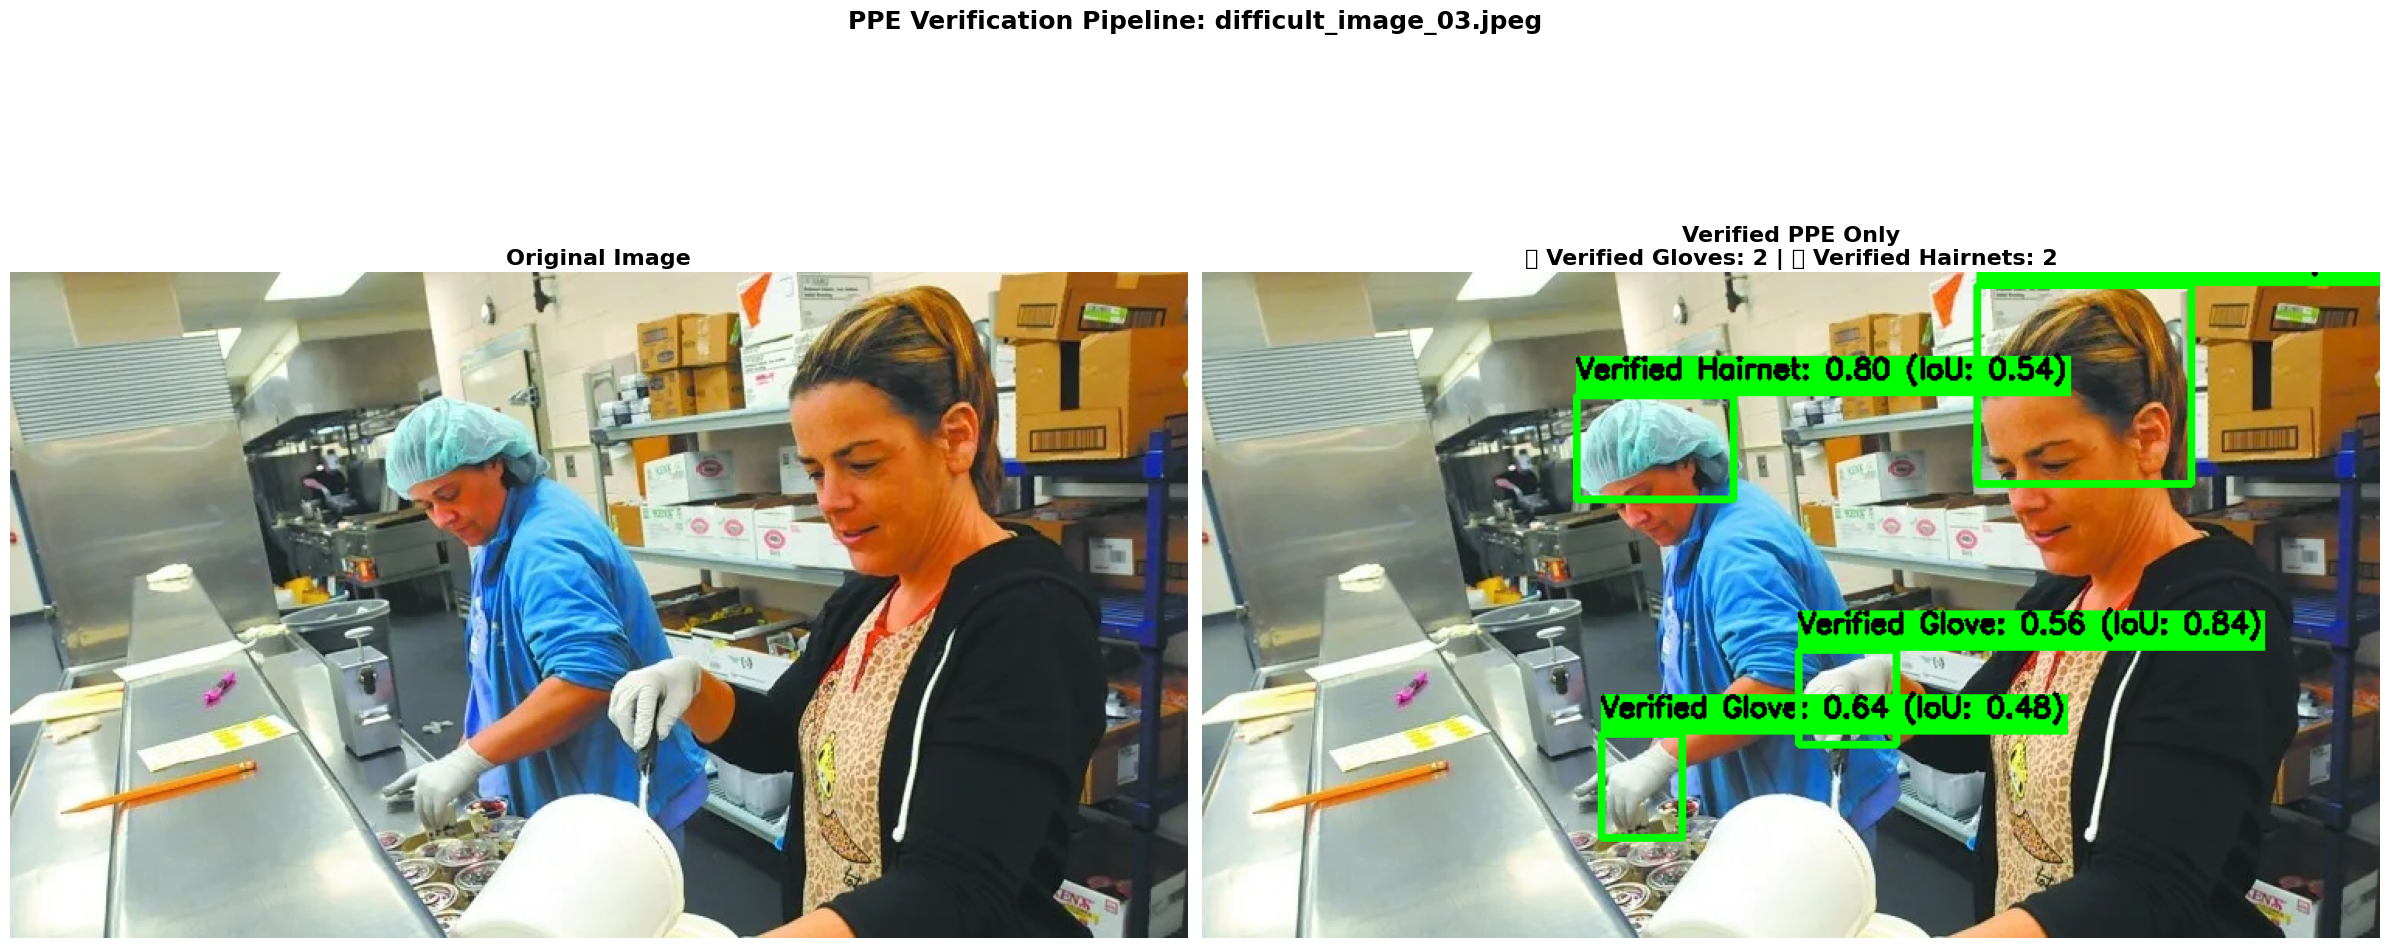


✅ Verification complete! Saved as 'ppe_verification.png'


In [113]:
# ==================== PPE VERIFICATION CONFIGURATION ====================
import cv2
import matplotlib.pyplot as plt
import numpy as np

# IoU thresholds for verification
GLOVE_HAND_IOU_THRESHOLD = 0.3   # Glove must overlap with hand by at least 30%
HAIRNET_HEAD_IOU_THRESHOLD = 0.3  # Hairnet must overlap with head by at least 30%

print("🔍 PPE Verification Pipeline")
print("="*60)
print(f"Configuration:")
print(f"  Glove-Hand IoU Threshold: {GLOVE_HAND_IOU_THRESHOLD}")
print(f"  Hairnet-Head IoU Threshold: {HAIRNET_HEAD_IOU_THRESHOLD}")
print("="*60)

# ==================== HELPER FUNCTIONS ====================
def calculate_iou(box1, box2):
    """
    Calculate IoU between two boxes in [x1, y1, x2, y2] format.
    Returns: float (0.0 to 1.0)
    """
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    inter_width = max(0, x2_inter - x1_inter)
    inter_height = max(0, y2_inter - y1_inter)
    intersection = inter_width * inter_height

    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection

    return intersection / union if union > 0 else 0

# ==================== EXTRACT BOUNDING BOXES ====================
# Extract glove detections
glove_boxes = []
glove_class_names = glove_model.names
for box in glove_results[0].boxes:
    cls_id = int(box.cls[0])
    cls_name = glove_class_names[cls_id]

    # Apply class filter and only get 'glove' class
    if (GLOVE_CLASSES is None or cls_name in GLOVE_CLASSES) and cls_name == 'glove':
        glove_boxes.append({
            'bbox': box.xyxy[0].cpu().numpy().tolist(),
            'confidence': float(box.conf[0]),
            'class': cls_name
        })

# Extract hand detections (validators)
hand_boxes = []
instances = outputs["instances"]
if len(instances) > 0:
    boxes_tensor = instances.pred_boxes.tensor.cpu().numpy()
    scores = instances.scores.cpu().numpy()

    for box, score in zip(boxes_tensor, scores):
        hand_boxes.append({
            'bbox': box.tolist(),
            'confidence': float(score)
        })

# Extract hairnet detections
hairnet_boxes = []
for box in hairnet_results[0].boxes:
    cls_id = int(box.cls[0])
    cls_name = data_config['names'][cls_id]

    # Apply class filter and only get 'hairnet' class
    if (HAIRNET_CLASSES is None or cls_name in HAIRNET_CLASSES) and cls_name == 'hairnet':
        hairnet_boxes.append({
            'bbox': box.xyxy[0].cpu().numpy().tolist(),
            'confidence': float(box.conf[0]),
            'class': cls_name
        })

# Extract head detections (validators)
head_boxes = []
head_class_names = head_model.names
for box in head_results[0].boxes:
    cls_id = int(box.cls[0])
    cls_name = head_class_names[cls_id]

    # Apply class filter and only get 'head' class
    if (HEAD_CLASSES is None or cls_name in HEAD_CLASSES) and cls_name == 'head':
        head_boxes.append({
            'bbox': box.xyxy[0].cpu().numpy().tolist(),
            'confidence': float(box.conf[0]),
            'class': cls_name
        })

print(f"\nExtracted Detections:")
print(f"  Gloves: {len(glove_boxes)}")
print(f"  Hands: {len(hand_boxes)}")
print(f"  Hairnets: {len(hairnet_boxes)}")
print(f"  Heads: {len(head_boxes)}")

# ==================== VERIFY GLOVES ====================
verified_gloves = []
rejected_gloves = []

for glove in glove_boxes:
    max_iou = 0.0
    best_hand = None

    # Find best overlapping hand
    for hand in hand_boxes:
        iou = calculate_iou(glove['bbox'], hand['bbox'])
        if iou > max_iou:
            max_iou = iou
            best_hand = hand

    # Verify if IoU meets threshold
    if max_iou >= GLOVE_HAND_IOU_THRESHOLD:
        verified_gloves.append({
            **glove,
            'verified': True,
            'verification_iou': max_iou,
            'validator_bbox': best_hand['bbox'] if best_hand else None
        })
    else:
        rejected_gloves.append({
            **glove,
            'verified': False,
            'max_iou': max_iou
        })

# ==================== VERIFY HAIRNETS ====================
verified_hairnets = []
rejected_hairnets = []

for hairnet in hairnet_boxes:
    max_iou = 0.0
    best_head = None

    # Find best overlapping head
    for head in head_boxes:
        iou = calculate_iou(hairnet['bbox'], head['bbox'])
        if iou > max_iou:
            max_iou = iou
            best_head = head

    # Verify if IoU meets threshold
    if max_iou >= HAIRNET_HEAD_IOU_THRESHOLD:
        verified_hairnets.append({
            **hairnet,
            'verified': True,
            'verification_iou': max_iou,
            'validator_bbox': best_head['bbox'] if best_head else None
        })
    else:
        rejected_hairnets.append({
            **hairnet,
            'verified': False,
            'max_iou': max_iou
        })

# ==================== PRINT SUMMARY ====================
print("\n" + "="*60)
print("PPE VERIFICATION SUMMARY")
print("="*60)
print(f"\n GLOVES:")
print(f"  Total detected: {len(glove_boxes)}")
print(f"  ✅ Verified: {len(verified_gloves)}")
print(f"  ❌ Rejected: {len(rejected_gloves)}")
if rejected_gloves:
    print(f"     (No overlapping hand or IoU < {GLOVE_HAND_IOU_THRESHOLD})")

print(f"\n HAIRNETS:")
print(f"  Total detected: {len(hairnet_boxes)}")
print(f"  ✅ Verified: {len(verified_hairnets)}")
print(f"  ❌ Rejected: {len(rejected_hairnets)}")
if rejected_hairnets:
    print(f"     (No overlapping head or IoU < {HAIRNET_HEAD_IOU_THRESHOLD})")
print("="*60)

# ==================== VISUALIZE VERIFIED PPE ONLY ====================
# Read image
img_verified = cv2.imread(sample_image)
img_verified = cv2.cvtColor(img_verified, cv2.COLOR_BGR2RGB)

# Colors for verified PPE
COLOR_VERIFIED_GLOVE = (0, 255, 0)      # Green (verified)
COLOR_VERIFIED_HAIRNET = (0, 255, 0)    # Green (verified)

# Draw verified gloves
for glove in verified_gloves:
    x1, y1, x2, y2 = [int(c) for c in glove['bbox']]
    conf = glove['confidence']
    iou = glove['verification_iou']

    # Draw bounding box
    cv2.rectangle(img_verified, (x1, y1), (x2, y2), COLOR_VERIFIED_GLOVE, 3)

    # Draw label
    label = f"Verified Glove: {conf:.2f} (IoU: {iou:.2f})"
    (label_w, label_h), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
    cv2.rectangle(img_verified, (x1, y1 - label_h - baseline - 5),
                 (x1 + label_w, y1), COLOR_VERIFIED_GLOVE, -1)
    cv2.putText(img_verified, label, (x1, y1 - baseline - 5),
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

# Draw verified hairnets
for hairnet in verified_hairnets:
    x1, y1, x2, y2 = [int(c) for c in hairnet['bbox']]
    conf = hairnet['confidence']
    iou = hairnet['verification_iou']

    # Draw bounding box
    cv2.rectangle(img_verified, (x1, y1), (x2, y2), COLOR_VERIFIED_HAIRNET, 3)

    # Draw label
    label = f"Verified Hairnet: {conf:.2f} (IoU: {iou:.2f})"
    (label_w, label_h), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
    cv2.rectangle(img_verified, (x1, y1 - label_h - baseline - 5),
                 (x1 + label_w, y1), COLOR_VERIFIED_HAIRNET, -1)
    cv2.putText(img_verified, label, (x1, y1 - baseline - 5),
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

# Display result
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

# Left: Original image
img_original = cv2.imread(sample_image)
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
axes[0].imshow(img_original)
axes[0].axis('off')
axes[0].set_title('Original Image', fontsize=16, fontweight='bold')

# Right: Verified PPE only
axes[1].imshow(img_verified)
axes[1].axis('off')
title = f'Verified PPE Only\n'
title += f'✅ Verified Gloves: {len(verified_gloves)} | ✅ Verified Hairnets: {len(verified_hairnets)}'
axes[1].set_title(title, fontsize=16, fontweight='bold')

plt.suptitle(f'PPE Verification Pipeline: {sample_image.split("/")[-1]}',
             fontsize=18, fontweight='bold')
plt.tight_layout()
plt.savefig('ppe_verification.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Verification complete! Saved as 'ppe_verification.png'")